In [176]:
from numpy import *
from numpy.linalg import *
from scipy.integrate import *
from scipy.signal import *

%matplotlib notebook
from matplotlib.pyplot import *
from matplotlib.animation import FuncAnimation
rcParams["figure.figsize"] = (10,6)

Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\user\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


Chariot Model
==============

We consider a mobile robot of "chariot" type, evolving in the plane.
From above, its frame appears to be a disk of diameter $D$. It has two fixed wheels (their orientation does not change), which are parallel and located at opposite ends of the frame (hence separated by a distance of $D$) ;
these wheels have the common radius $R$.

The robot is symmetric with respect to the axis that joins the two wheels. For convenience, a green sticker is attached at the boundary of the frame on one side of this axis, on the robot axis of symmetry ; this side will is called the "front" of the robot, the point itself is called the "nose" of the robot. When we talk about the "left wheel" or the "right wheel", we assume that we are looking towards the front of the robot.

We will denote $(x, y)$ the coordinates of the wheel axis in the orthonormal frame $(0, e_x, e_y)$ of the plane. The angle $\theta$ refers to the angle of the wheels direction with respect to vector $e_x$ ; with
$\theta = 0$ when the front of the robot faces the right and $\theta = \pi/2$ when he faces the top.
We will denote $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the robot moves forward.

### Task - Parameter Definition


From now on, we assume that the frame diameter is $D = 1 \mbox{ m}$ and the wheel radius is $R = 10 \mbox{ cm}$.
Define the corresponding Python variables `D` and `R` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [177]:
D = 1
R = 0.1

### Task - Graphical Representation

Use `matplotlib` to draw an image of the robot in the plane for arbitrary values of $(x, y)$ and $\theta$. The frame will be represented as a circle, the wheels as lines and the nose as a green point.

<IPython.core.display.Javascript object>


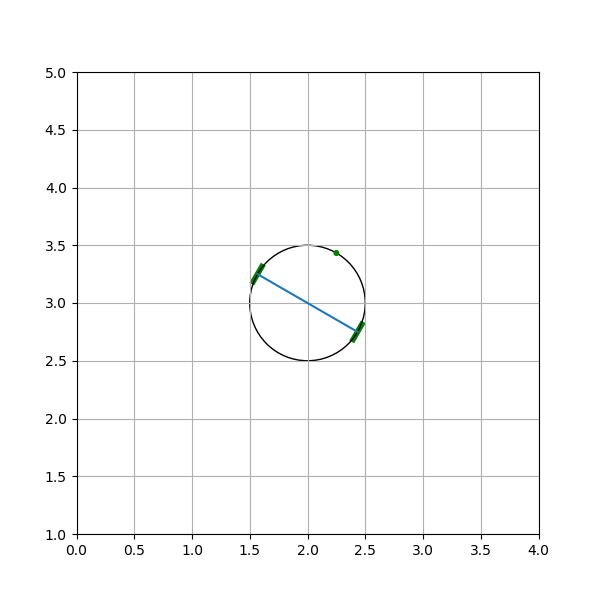

In [178]:
matplotlib.rcParams['figure.figsize'] = [6, 6]

e = 0.05

# Robot position
x = 0
y = 0
theta = 2*pi



def rotate(x, y, theta):
  return (x*cos(theta - pi / 2) - y*sin(theta - pi / 2), y*cos(theta - pi / 2) + x*sin(theta - pi / 2))

def draw_robot(x, y, theta):
  
  # Pre-configuration
  figure()
  axes = gca()
  axes.axis([-2*D + x, 2*D + x, -2*D + y, 2*D + y])
  axes.set_aspect(1)
  grid(True)

  # Create Circles
  circle1 = Circle((x, y), D/2, color='black', fill=False)
  circle2 = Circle((rotate(0, D/2, theta)[0] + x, rotate(0, D/2, theta)[1] + y), 0.02, color='green')

  # Create a Rectangle patch
  rect_right = Rectangle((rotate(D/2, -R, theta)[0] + x, rotate(D/2, -R, theta)[1] + y), 0, 2*R, angle=degrees(theta - pi /2), linewidth=4, edgecolor='green', facecolor='none')
  rect_left = Rectangle((rotate(-D/2, -R, theta)[0] + x, rotate(-D/2, -R, theta)[1] + y), 0, 2*R, angle=degrees(theta - pi/2), linewidth=4, edgecolor='green', facecolor='none')

  # Create a Line
  point1 = [-(D*cos(theta - pi/2)/2) + x, -(D*sin(theta - pi/2)/2) + y]
  point2 = [(D*cos(theta - pi/2)/2) + x , (D*sin(theta - pi/2)/2) + y]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]



  # Add the patch to the Axes
  axes.add_patch(rect_right)
  axes.add_patch(rect_left)
  axes.add_patch(circle1)
  axes.add_patch(circle2)
  plot(x_values, y_values)
  draw()

draw_robot(2, 3, pi/3)

### Task - Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the robot).
We also assume that the chariot wheels roll without slipping. 

Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

We've got $$v_l=Rw_l$$
and $$v_r=Rw_r$$
then $$v=\frac{1}{2}v_l+\frac{1}{2}v_r=\frac{R}{2}(\omega_l+\omega_r)$$

Given that one wheel is fixed (i.e. the left wheel) and the other moves a distance $x_r$, we obtain:
 
$$\dot x_r=R\omega_r=D\dot \theta_1$$
so $$\dot \theta_1=\frac{R}{D}\omega_r$$
 
When we repeat the process with the other wheel, but this time with a (-) to indicate the opposite direction of rotation, we get:

$$\dot \theta_2=-\frac{R}{D}\omega_l$$
thus $$\omega=\frac{R}{D}(\omega_r-\omega_l)$$
We can get the following result by projecting the vector $v$ on $e_x$ and $e_y$:
$$\dot x=v_x=\frac{R}{2}(\omega_l+\omega_r)cos(\theta)$$
$$\dot y=v_y=\frac{R}{2}(\omega_l+\omega_r)sin(\theta)$$
As a result, we have a system of differential equations:

$$\begin{cases} \dot x=\frac{R}{2}(\omega_l+\omega_r)cos(\theta) \\ \dot y=\frac{R}{2}(\omega_l+\omega_r)sin(\theta) \\  \dot \theta=\frac{R}{D}(\omega_r-\omega_l)
\end{cases}$$


### Task - Model Implementation

Implement a function `f` that computes $\dot{X} = (\dot{x}, \dot{y}, \dot{\theta})$ given $X = (x,y,\theta)$ 
and $\omega = (\omega_l, \omega_r)$.


In [179]:
def f(t, X, omega):
    x, y, theta = X
    omega_l, omega_r = omega
    dx=(R/2)*(omega_r+omega_l)*cos(theta)
    dy=(R/2)*(omega_r+omega_l)*sin(theta)
    dtheta=(R/D)*(omega_r-omega_l)
    dX = array([dx, dy, dtheta])
    return dX

### Task - Simulation Setup

Show how the `solve_ivp` function can be used to solve the system dynamics on a span of 10 secs when:

  - $\omega$ is constant, equal to $\omega_0 = (\omega_{l0}, \omega_{r0})$ and
  
  - $X_0 = (x_0, y_0, \theta_0)$.
  
  

In [180]:
def simulate(Ol=0.5, Or=0.5, x0=0, y0=0, theta0=pi/2):
  omega_l0 = Ol
  omega_r0 = Or
  omega0 = [omega_l0, omega_r0]
  print("Ol = ",Ol," Or= ", Or, " x0 = ", x0," y0 = ", y0," theta0 = ", theta0)

  def fun(t,X):
    return f(t, X, omega0)

  #Set an intervale of 10 seconds
  t_span = [0.0, 10.0]

  #Initial values
  X0 = [x0, y0, theta0]
  result = solve_ivp(fun=fun, t_span=t_span, y0=X0, dense_output=True, max_step=0.1)

  Int=linspace(0, 10.0, 1000)

  x, y, theta = result['sol'](Int)

  figure()
  plot(Int,x,"b", label='$x$')
  plot(Int,y,"g", label='$y$')
  plot(Int,theta,"r", label='$theta$')
  plot(x,y, 'k--', label='$y(x)$')
  legend()
  grid(True)

Ol =  0.5  Or=  0.5  x0 =  0  y0 =  0  theta0 =  1.5707963267948966


<IPython.core.display.Javascript object>


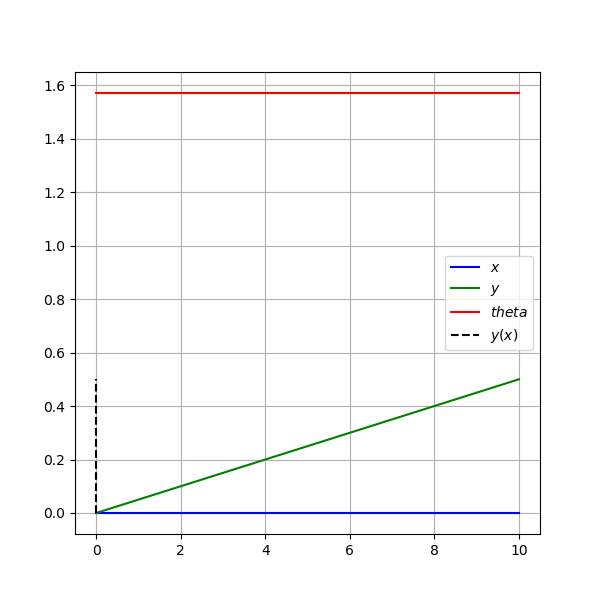

In [181]:
simulate()

### Task: Simulation Validation
 
  
We would like to validate the results of our simulation code at this stage. 

To do this, select a few initials conditions $X_0$ and values of $\omega_0$ that are "as different as possible" (we want to check that our simulation of the dynamics works in all cases) for which the analytical solution is know. Compute these solutions, then, plot $x$, $y$ and $\theta$ as functions of the time $t$ and check that the result is consistent.

Ol =  3.5782533442936404  Or=  3.8333293204311936  x0 =  -5.9836049305694194  y0 =  3.6546928389630384  theta0 =  -1.7607339284169496


<IPython.core.display.Javascript object>


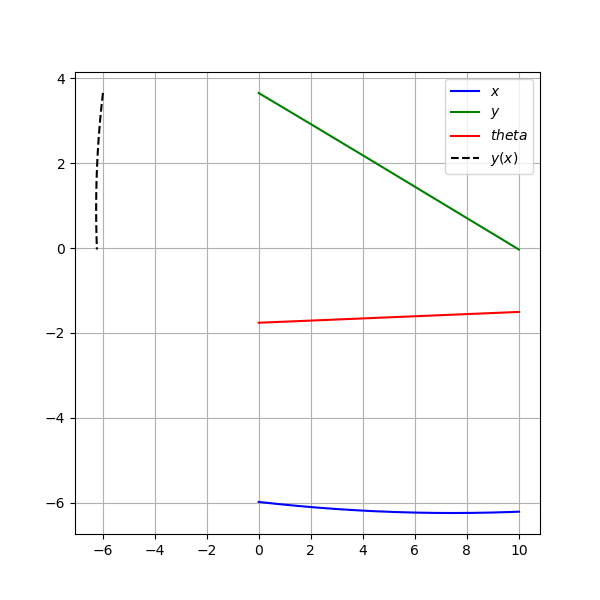

In [182]:
from random import random
simulate(Ol=(random()-0.5)*20, Or=(random()-0.5)*20, x0=(random()-0.5)*20, y0=(random()-0.5)*20, theta0=(random()-0.5)*2*pi)

### Task: Time-dependent Inputs

Provide a simulation code that handles the case of time-dependent angular velocities $\omega_l$ and $\omega_r$, for example:
    

In [183]:
def omega_l(t):
    if t <= 5.0:
        return pi * D
    else:
        return 0.0
    
def omega_r(t):
    if t >= 5.0:
        return pi * D
    else:
        return 0.0

In [184]:
def simulate_time(x0=0, y0=0, theta0=pi/2):

  print("x0 = ", x0," y0 = ", y0," theta0 = ", theta0)

  def fun(t,X):
    omega=[omega_l(t),omega_r(t)]
    return f(t, X, omega)

  #Set an intervale of 10 seconds
  t_span = [0.0, 10.0]

  #Initial values
  X0 = [x0, y0, theta0]
  result = solve_ivp(fun=fun, t_span=t_span, y0=X0, dense_output=True, max_step=0.1)

  Int=linspace(0, 10.0, 1000)

  x, y, theta = result['sol'](Int)

  figure()
  plot(Int,x,"b", label='x')
  plot(Int,y,"g", label='y')
  plot(Int,theta,"r", label='theta')
  plot(x, y, 'k--', label='y en fonction de x')
  legend()
  grid(True)

x0 =  0.9322059147008344  y0 =  0.3762224583084284  theta0 =  1.2618959456408885


<IPython.core.display.Javascript object>


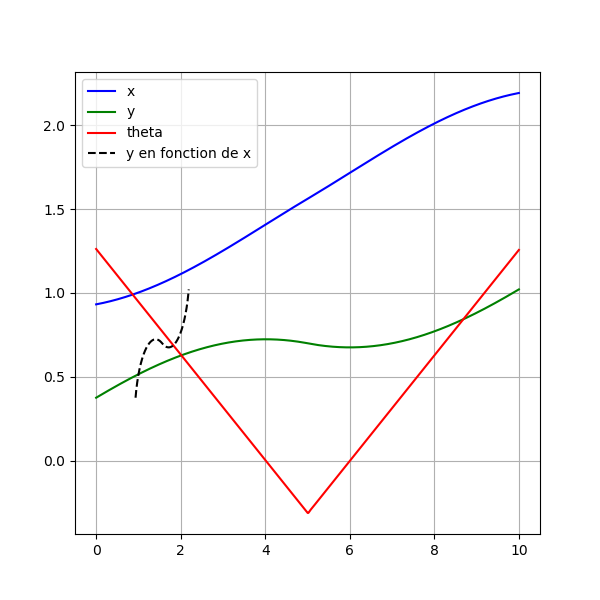

In [185]:
simulate_time(x0=(random()-0.5)*20, y0=(random()-0.5)*20, theta0=(random()-0.5)*2*pi)

### Task: Validation

Compute the analytical solution for $X_0 = (0.0, 0.0, 0.0)$ for the time-dependent $\omega(t)$ example and check that your simulation code outputs consistent results.

x0 =  0  y0 =  0  theta0 =  0


<IPython.core.display.Javascript object>


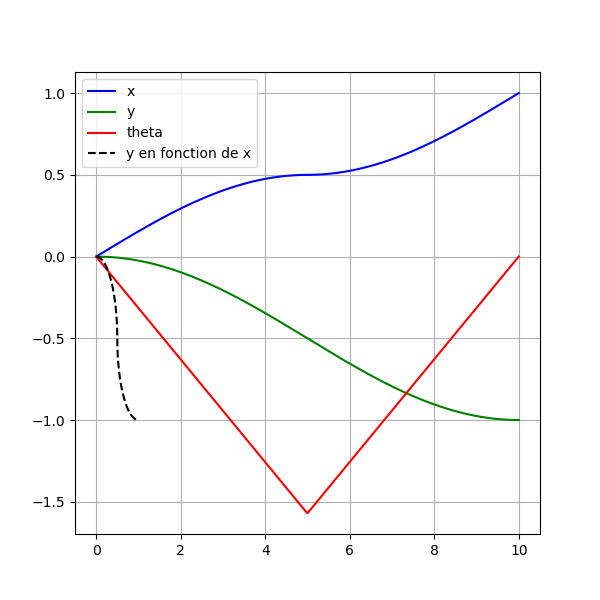

In [186]:
simulate_time(x0=0, y0=0, theta0=0)

### Task: User-defined Sample Times

Adapt your simulation code to generate arrays `x`, `y` and `theta` which correspond to a given array of time values `t` in $[0.0, 10.0]$. Test the code with `t = arange(0.0, 10.0, dt)` where `dt = 1.0 / 60.0` ; in this case we get a state update 60 times per second, something that is appropriate to display animations.

x0 =  0  y0 =  0  theta0 =  0.7853981633974483


<IPython.core.display.Javascript object>


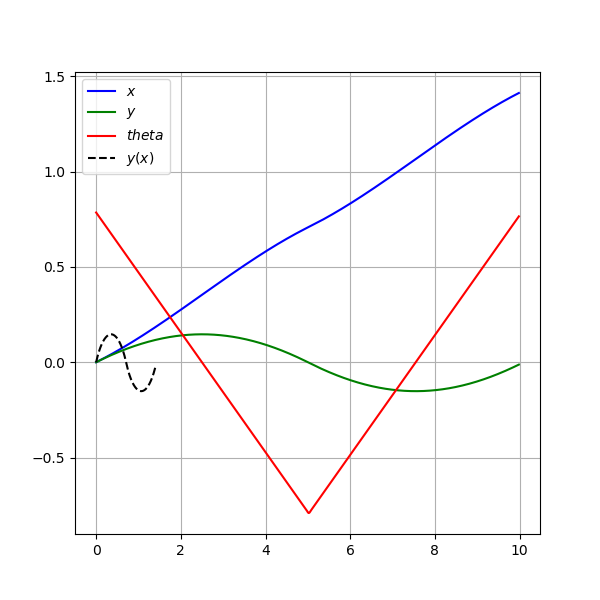

In [187]:
def simulate_time_dt(x0=0, y0=0, theta0=pi/4):

  print("x0 = ", x0," y0 = ", y0," theta0 = ", theta0)

  def fun(t,X):
    omega=[omega_l(t),omega_r(t)]
    return f(t, X, omega)

  #Set an intervale of 10 seconds
  t_span = [0.0, 10.0]

  #Initial values
  X0 = [x0, y0, theta0]
  result = solve_ivp(fun=fun, t_span=t_span, y0=X0, dense_output=True, max_step=0.1)

  deltat=1.0 / 60.0

  Int = arange(0.0, 10.0, deltat)

  x, y, theta = result['sol'](Int)

  figure()
  plot(Int,x,"b", label='$x$')
  plot(Int,y,"g", label='$y$')
  plot(Int,theta,"r", label='$theta$')
  plot(x, y, 'k--', label='$y(x)$')
  legend()
  grid(True)


simulate_time_dt()

### Task: Animation

For each of the use cases considered so far, compute the solution as arrays `x`, `y` and `theta` which correspond to `t = arange(0.0, 10.0, dt)` where `dt = 1.0 / 60.0` and display the result of this simulation graphically as an animated robot in the plane. Refer to [this example notebook](https://github.com/boisgera/control-engineering-with-python/blob/master/examples/animation.ipynb) if necessary.

In [188]:
def fun(t,X):
    omega=[omega_l(t),omega_r(t)]
    return f(t, X, omega)

#Set an intervale of 10 seconds
t_span = [0.0, 10.0]

#Initial values
X0 = [0, 0, 0]
result = solve_ivp(fun=fun, t_span=t_span, y0=X0, dense_output=True, max_step=0.1)
deltat=1.0 / 60.0

Int = arange(0.0, 10.0, deltat)

x, y, theta = result['sol'](Int)

<IPython.core.display.Javascript object>


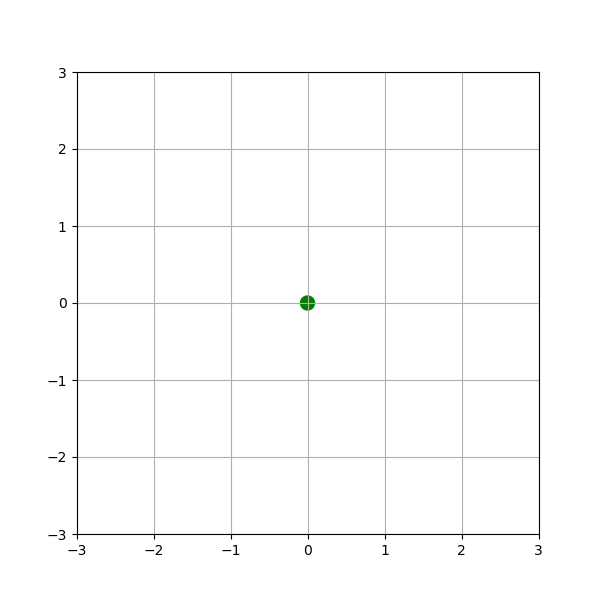

In [189]:
direct = linspace(0, 2*pi, 1000)

fig = figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3))
ax.set_aspect('equal')
ax.grid()

lines = [plot([],[])[0] for _ in range(4)]
circle = Circle([0.0, 0.0], radius=0.1, fc="g")
ax.add_artist(circle)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for line in lines:
        line.set_data([],[])
        line.set_color("k")
        time_text.set_text('')
    return lines, circle, time_text

def animate(i):
    x1 = x[i]+(D/2)*cos(direct)
    x2 = y[i]+(D/2)*sin(direct)
    lines[0].set_data(x1,x2)
    
    x0r=x[i]+(D/2)*sin(theta[i])
    y0r=y[i]-(D/2)*cos(theta[i])
    xrw=linspace(x0d-R*cos(theta[i]),x0d+R*cos(theta[i]),2)
    yrw=y0d+(xrw-x0d)*tan(theta[i])
    lines[1].set_data(xrw,yrw)
    
    x0l=x[i]+(D/2)*sin(theta[i]+pi)
    y0l=y[i]-(D/2)*cos(theta[i]+pi)
    xlw=linspace(x0l-R*cos(theta[i]),x0l+R*cos(theta[i]),2)
    ylw=y0l+(xlw-x0l)*tan(theta[i])
    lines[2].set_data(xlw,ylw)
    
    y1 = x[0:i+1]
    y2 = y[0:i+1]
    lines[3].set_data(y1,y2)
    
    circle.center = [x[i]+(D/2)*cos(theta[i]),y[i]+(D/2)*sin(theta[i])]
    time_text.set_text(time_template % (i*deltat))
    return lines, circle, time_text

ani = FuncAnimation(fig, animate, init_func=init, frames=range(0,len(Int)), blit=True, interval=deltat*1000, repeat=False)

show()

Local Control in a Lane
===================

At Rest
--------------------------------------

### Task : Equilibrium

Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the mobile robot.

Show that for any other $\omega_e$, the system has no equilibrium.

Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

We have $$f(t, X_e)=0 \iff \begin{cases} \omega_r = - \omega_l \\ \omega_r = \omega_l
\end{cases}$$
thus $\omega_r = \omega_l = 0 $

so for $\omega_e=(0,0)$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the mobile robot.

There is only one solution to the problem we just solved, which is e = (0,0). Furthermore, if we use the plots and give the robot a speed other than 0, it will always move.

All states of the system are equilibria if the speed is e.

### Task : Linearized System


Let $\omega = \omega_e$ and $X_e = (0,0,0)$.

Introduce the error variables $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$.
Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$.

We have $$ \dot{X}= AX + BU $$

we have the matrix $$A = 
\left[ 
\begin{array}{ccc}
\frac{\partial{f}}{\partial{x}}  & \frac{\partial{f}}{\partial{y}}  & \frac{\partial{f}}{\partial{\theta}}
\end{array}
\right]
\;$$
where $$
f = \left[
  \begin{array}{c}
  \frac{R}{2}(\omega_l+\omega_r)cos(\theta) \\ \frac{R}{2}(\omega_l+\omega_r)sin(\theta) \\ \frac{R}{D}(\omega_r-\omega_l)
  \end{array} 
  \right] $$ 
thus we obtain : 
 $$ A = \left[ 
\begin{array}{ccc}
0 & 0  & \frac{R}{2}(\omega_l-\omega_r)sin(\theta) \\
0 & 0 & \frac{R}{2}(\omega_l+\omega_r)cos(\theta) \\
0 & 0 & 0
\end{array}
\right]
\;$$
we linearize considering $\theta=0$, on a : 
$$ A = \left[ 
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & \frac{R}{2}(\omega_l+\omega_r) \\
0 & 0 & 0
\end{array}
\right]
\;$$
Otherwise, we have : $$ B = 
\left[ 
\begin{array}{cc}
\frac{\partial{f}}{\partial{\omega_{r}}}  & \frac{\partial{f}}{\partial{\omega_{l}}}
\end{array}
\right]
\;$$
thus : 
 $$ B = \left[ 
\begin{array}{cc}
\frac{R}{2}cos(\theta) & \frac{R}{2}cos(\theta)  \\
\frac{R}{2}sin(\theta) & \frac{R}{2}sin(\theta) \\
\frac{R}{D} & \frac{-R}{D} 
\end{array}
\right]
\;$$
and for $\theta=0$ the matrix become : 
$$B = \left[ 
\begin{array}{cc}
\frac{R}{2} & \frac{R}{2} \\
0 & 0  \\
\frac{R}{D} & \frac{-R}{D} 
\end{array}
\right]
\;$$

### Task : Stability Analysis


Is the linearized system asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ ?

Is the original system asymptotically stable ? Or even (locally) attractive ? Justify your answers.

In [190]:
A = array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
B = array([[R/2, R/2], [0, 0], [R/D, -R/D]])

After replacing $\omega_l$ and $\omega_r$ by 0, we obtain $ A = \left[ 
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{array}
\right]
\;$ 
so $sp(A) = {0}$
The asymptotic stability condition is not confirmed since the values must be negative.
therefore, it's not attractive.

### Task : Linearized System
Show that the linearized system is not controllable. 

In [191]:
mp=matrix_power
M=B
M=c_[B, A @ B, mp(A,2) @  B]

print(M)
print(matrix_rank(M))

[[ 0.05  0.05  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.1  -0.1   0.    0.    0.    0.  ]]
2


Since $
  \mathrm{rang} \, \left[B, AB, A^{2} B\right] = 2 \neq 3
  $ then our system is not controllable.

### Task : Straight Line

Let $x_r(t) = v t$ and $y_r(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$. Determine the set of trajectories $X_r(t) = (x_r(t), y_r(t), \theta_r(t))$ which are admissible and compute the corresponding reference control $\omega_r(t)$.

We have $X_r(t) = (vt, 0, \theta_r(t))$ 

We solve the equation: $\frac{dX_r(t)}{dt} = f(t, X)$ 

We obtain $f(t, X) = (vcos(\theta), vsin(\theta), \omega)$ 

We find two trajectories possible for the system :

if $\theta = 2k\pi$ then $\omega_r(t) = (\frac{v}{R}, \frac{v}{R}) \Longrightarrow$ the robot moves forward.

and if $\theta = 2(k+1)\pi$ then $\omega_r(t) = (\frac{-v}{R}, \frac{-v}{R}) \Longrightarrow$ the robot moves backward.

### Task : Linearized System

Let $\Delta X(t) = X(t) - X_r(t)$ and $\Delta \omega(t) = \omega(t) - \omega_r(t)$. Compute the linearized dynamics of the system. Is the system asymptotically stable ? Attractive ?

We have : 
 $$ A = \left[ 
\begin{array}{ccc}
0 & 0  & \frac{R}{2}(\omega_l-\omega_r)sin(\theta) \\
0 & 0 & \frac{R}{2}(\omega_l+\omega_r)cos(\theta) \\
0 & 0 & 0
\end{array}
\right]
\;$$

we replace $\omega_l=\frac{v}{R}$ and $\omega_r=\frac{v}{R}$ and $\theta$ considering $v=1$ and $\theta=0$:

$$ A = \left[ 
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & \frac{R}{2}(\frac{v}{R}+\frac{v}{R}) \\
0 & 0 & 0
\end{array}
\right]
= \left[ 
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & v \\
0 & 0 & 0
\end{array}
\right]$$

In [192]:
v=1
A = array([[0, 0, 0], [0, 0, v], [0, 0, 0]])
B = array([[R/2, R/2], [0, 0], [R/D, -R/D]])

In [193]:
eig(A)

(array([0., 0., 0.]),
 array([[ 1.00000000e+000,  0.00000000e+000,  0.00000000e+000],
        [ 0.00000000e+000,  1.00000000e+000, -1.00000000e+000],
        [ 0.00000000e+000,  0.00000000e+000,  3.00625254e-292]]))

We have $sp(A) = {0}$
The asymptotic stability condition is not confirmed since the values must be negative.
therefore, it's not attractive.

### Task : Linearized System
Show that the linearized system is controllable.

In [194]:
mp=matrix_power
M=B
M=c_[B, A @ B, mp(A,2) @  B]

print(M)
print(matrix_rank(M))

[[ 0.05  0.05  0.    0.    0.    0.  ]
 [ 0.    0.    0.1  -0.1   0.    0.  ]
 [ 0.1  -0.1   0.    0.    0.    0.  ]]
3


Since $
  \mathrm{rang} \, \left[B, AB, A^{2} B\right] = 3
  $ then our system is controllable.

### Task : Controller Design

Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location. Select a location of the poles that asymptotically stabilizes the system.



We consider $$ U = -KX$$
so $$ \dot{X}=(A-BK)X $$

In [195]:
poles = [-1, -3, -2]  #valeurs propres 
K = place_poles(A, B, poles).gain_matrix
print(K)
ev,_= eig(A-B@K)
print(ev)

[[ 20.00097788  15.01955853  20.00977879]
 [ 19.99902212 -14.98044338 -19.99022121]]
[-2. -3. -1.]


The asymptotic stability condition is verified since the values are negative.

### Task: Controller Tuning I

We assume that the reference velocity $v$ is $10$ km/h and that the robot starts at $X(0) = (0.0, 2.0, 0.0)$.
Tune the poles so that the actual location $(x, y)$ is within 10 cm of the desired location within 10 sec and the linear velocity of each wheel never exceeds $15$ km/h.

Plot the evolution of the robot angle. Why is it important to check that this angle stays small ?

<IPython.core.display.Javascript object>


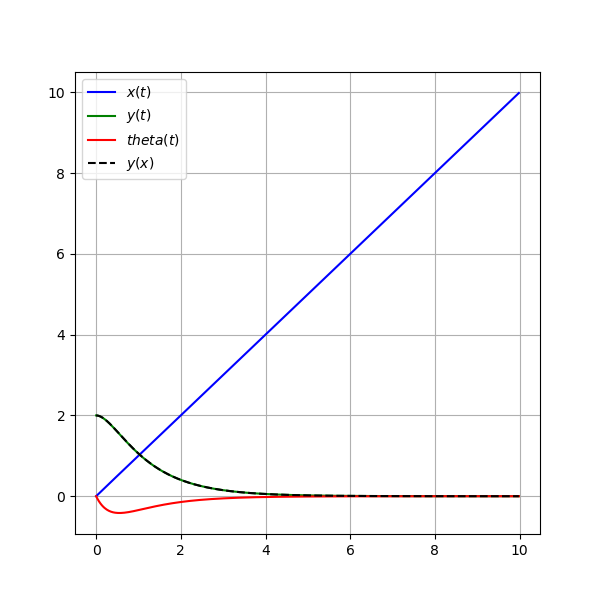

In [196]:
A = array([[0, 0, 0], [0, 0, 10/3.6], [0, 0, 0]])
B = array([[R/2, R/2], [0, 0], [R/D, -R/D]])


poles=[-1.0,-2.0,-3.0]
K=place_poles(A,B,poles).gain_matrix
K

def f(t, y):
    return (A-B@K)@y.T


X0=[0,2,0]
t_span = [0, 10]
result = solve_ivp(fun=f, t_span=t_span, y0=X0, dense_output= True, max_step = 0.1)
x=result["sol"](Int)[0]+v*Int
y=result["sol"](Int)[1]
theta=result["sol"](Int)[2]
omega_l=(v/R)-K[0,0]*result["sol"](Int)[0]-K[0,1]*y-K[0,2]*theta
omega_r=(v/R)-K[1,0]*result["sol"](Int)[0]-K[1,1]*y-K[1,2]*theta
figure()
plot(Int,x,"b",label="$x(t)$")
plot(Int,y,"g",label="$y(t)$")
plot(Int,theta,"r",label="$theta(t)$")
plot(x,y,"k--", label='$y(x)$')
grid(True)
legend()

<IPython.core.display.Javascript object>


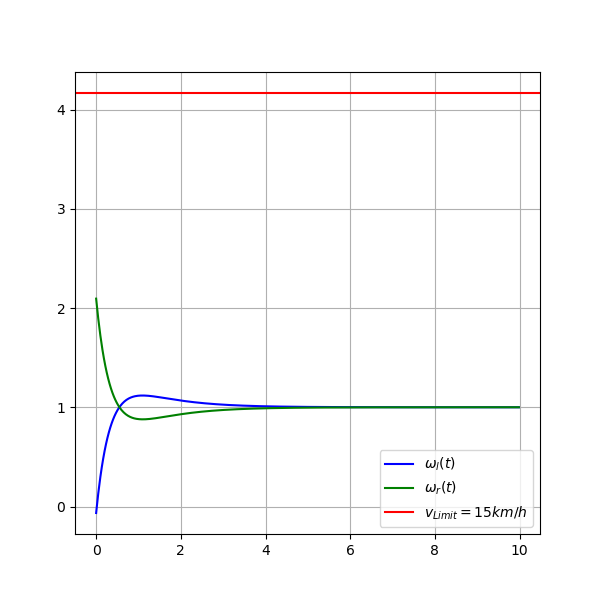

In [197]:
figure()
plot(Int,R*omega_l,"b",label="$\omega_l(t)$")
plot(Int,R*omega_r,"g",label="$\omega_r(t)$")
axhline(y=15.0/3.6,color="red",label="$v_{Limit}=15km/h$")
grid(True)
legend()

### Task: Controller Tuning II

Repeat the controller design and tuning steps above using an optimal control methodology.

In [198]:
from scipy.linalg import solve_continuous_are
P = array([[1, 0, 0], [0, 1, 0],[0, 0, 4]])
Q = array([[1,0],[0,1]])
Pi = solve_continuous_are(A, B, P, Q)
K = inv(Q) @ B.T @ Pi
eigenvalues, _ = eig(A - B @ K)
print(eigenvalues)

[-0.46520807+0.42002208j -0.46520807-0.42002208j -0.07071068+0.j        ]


<IPython.core.display.Javascript object>


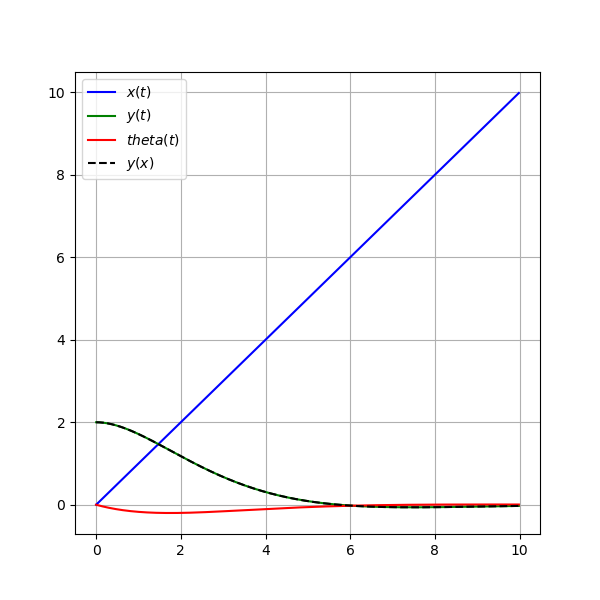

In [199]:
def f(t,y):
    return (A-B@K)@y.T
result=solve_ivp(fun=f,y0=X0,t_span=t_span,dense_output=True,max_step=0.1)
x=result["sol"](Int)[0]+v*Int
y=result["sol"](Int)[1]
theta=result["sol"](Int)[2]
omega_l=(v/R)-K[0,0]*result["sol"](Int)[0]-K[0,1]*y-K[0,2]*theta
omega_r=(v/R)-K[1,0]*result["sol"](Int)[0]-K[1,1]*y-K[1,2]*theta
figure()
plot(Int,x,"b",label="$x(t)$")
plot(Int,y,"g",label="$y(t)$")
plot(Int,theta,"r",label="$theta(t)$")
plot(x,y,"k--",label="$y(x)$")
grid(True)
legend()

<IPython.core.display.Javascript object>


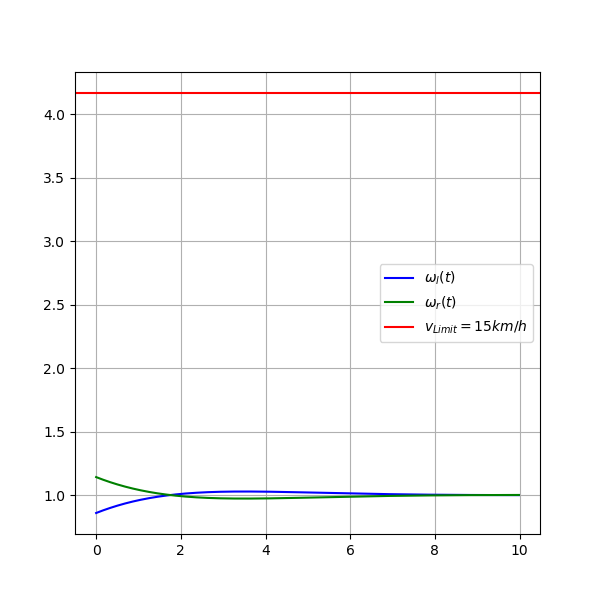

In [200]:
figure()
plot(Int,R*omega_l,"b",label="$\omega_l(t)$")
plot(Int,R*omega_r,"g",label="$\omega_r(t)$")
axhline(y=15.0/3.6,color="red",label="$v_{Limit}=15km/h$")
grid(True)
legend()

### Task: Controller Validation

Test your controller on the "true" (nonlinear) dynamics. Adjust the controller tuning is necessary.

Demonstrate the controller behavior with an animation of the robot.

<IPython.core.display.Javascript object>


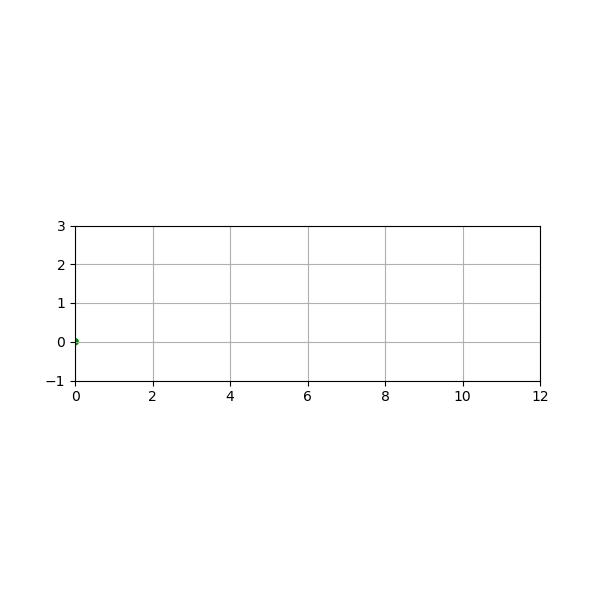

In [201]:
direct = linspace(0, 2*pi, 1000)

fig = figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0.0, 12), ylim=(-1, 3))
ax.set_aspect('equal')
ax.grid()

lines = [plot([],[])[0] for _ in range(4)]
circle = Circle([0.0, 0.0], radius=0.1, fc="g")
ax.add_artist(circle)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for line in lines:
        line.set_data([],[])
        line.set_color('k')
        time_text.set_text('')
    return lines, circle, time_text

def animate(i):
    x1 = x[i]+(D/2)*cos(direct)
    x2 = y[i]+(D/2)*sin(direct)
    lines[0].set_data(x1,x2)
    
    x0r=x[i]+(D/2)*sin(theta[i])
    y0r=y[i]-(D/2)*cos(theta[i])
    xrw=linspace(x0r-R*cos(theta[i]),x0r+R*cos(theta[i]),2)
    yrw=y0r+(xrw-x0r)*tan(theta[i])
    lines[1].set_data(xrw,yrw)
    
    x0l=x[i]+(D/2)*sin(theta[i]+pi)
    y0l=y[i]-(D/2)*cos(theta[i]+pi)
    xlw=linspace(x0l-R*cos(theta[i]),x0l+R*cos(theta[i]),2)
    ylw=y0l+(xlw-x0l)*tan(theta[i])
    lines[2].set_data(xlw,ylw)
    
    y1 = x[0:i+1]
    y2 = y[0:i+1]
    lines[3].set_data(y1,y2)
    
    circle.center = [x[i]+(D/2)*cos(theta[i]),y[i]+(D/2)*sin(theta[i])]
    time_text.set_text(time_template % (i*deltat))
    return lines, circle, time_text

ani = FuncAnimation(fig, animate, init_func=init, frames=range(0,len(Int)), blit=True, interval=deltat*1000, repeat=False)

show()

Global Control and General Trajectories
====================================

### Task - Nose Dynamics

Write the differential equation satisfied by the location $(x_n, y_n)$ of the robot nose. 

We have $$X_n=\begin{pmatrix}
x_n \\
y_n \\
\theta
\end{pmatrix}$$

With $$\begin{cases} x_n=x+\frac{D}{2}cos(\theta) \\ y_n=y+\frac{D}{2}sin(\theta)
\end{cases}$$

Thus $$\begin{cases} \dot{x_n}= \dot{x}-\frac{D}{2}\dot{\theta}sin(\theta) \\ \dot{y_n}=\dot{y}+\frac{D}{2}\dot{\theta}cos(\theta)
\end{cases}$$

We replace $\dot{x}$ and $\dot{y}$ by their formula, then we obtain the differential equation satisfied by the location $(𝑥_𝑛,𝑦_𝑛)$  of the robot nose:

$$\begin{cases} \dot{x_n}=\frac{R}{2}(\omega_l+\omega_r)cos(\theta)-\frac{D}{2}\dot{\theta}sin(\theta) \\ \dot{y_n}=\frac{R}{2}(\omega_l+\omega_r)sin(\theta)+\frac{D}{2}\dot{\theta}cos(\theta)
\end{cases}$$

### Task - Admissible Trajectoiries

Show any (smooth) reference evolution of the robot nose $(x_n^r(t), y_n^r(t))$ and any initial state of the robot consistent with the initial nose location, there is an admissible trajectory $(x(t), y(t), \theta(t))$ that corresponds to this reference. Hint: search the unique $\omega_l(t)$ and $\omega_r(t)$ -- as functions of $\dot{x}_n^r(t)$, $\dot{y}_n^r(t)$ and $\theta(t)$ -- that satisfies this property. 

We have $$\begin{cases} \dot{x_n}=\frac{R}{2}(\omega_l+\omega_r)cos(\theta)-\frac{D}{2}\dot{\theta}sin(\theta) \\ \dot{y_n}=\frac{R}{2}(\omega_l+\omega_r)sin(\theta)+\frac{D}{2}\dot{\theta}cos(\theta)
\end{cases}$$

So by multiplying $\dot{x_n}$ by $cos(\theta)$ then $-sin(\theta)$ and $\dot{y_n}$ by $sin(\theta)$ then $cos(\theta)$ then adding the two equations each time, we obtain:

$$\begin{cases} \dot{x_n}cos(\theta)+\dot{y_n}sin(\theta)=\frac{R}{2}(\omega_l+\omega_r)\\ \dot{y_n}cos(\theta)-\dot{x_n}sin(\theta)=\frac{D}{2}\dot{\theta}=\frac{R}{2}(\omega_r-\omega_l)
\end{cases}$$

So we obtain the formula of $\omega_r(t)$ and $\omega_l(t)$: $$ \begin{cases} \omega_r=\frac{2}{R}(\dot{x_n}cos(\theta)+\dot{y_n}sin(\theta)+\dot{y_n}cos(\theta)-\dot{x_n}sin(\theta))\\
 \omega_l=\frac{2}{R}(\dot{x_n}cos(\theta)+\dot{y_n}sin(\theta)-\dot{y_n}cos(\theta)+\dot{x_n}sin(\theta))
 \end{cases}$$

### Task - Stability

Let $v>0$ be the value in m/s that corresponds to $10$ km/h and let $(x_n^r(t), y_n^r(t)) = (vt, 0)$.
Simulate the robot evolution (with animation) with the choice for $\omega_l$ and $\omega_r$ of the previous question for different values of $X(0)$. In particular, investigate the case of à $\theta(0)$ close to $0$, then close to $\pi$. Is the system dynamics asymptotically stable in each case ?

In [202]:
v=10/3.6
def f(t, X):
    x, y, theta = X
    omega_l, omega_r=2*v*(cos(theta)+sin(theta))/R, 2*v*(cos(theta)-sin(theta))/R
    dx=(R/2)*(omega_r+omega_l)*cos(theta)
    dy=(R/2)*(omega_r+omega_l)*sin(theta)
    dtheta=(R/D)*(omega_r-omega_l)
    dX = array([dx, dy, dtheta])
    return dX

In [206]:
X0 = [0,0,0]
t_span = [0,10]
Int = linspace(0, 10.0, 1000)
result = solve_ivp(fun=f, t_span=t_span, y0=X0, dense_output=True, max_step=0.1)
x, y, theta = result['sol'](Int)

<IPython.core.display.Javascript object>


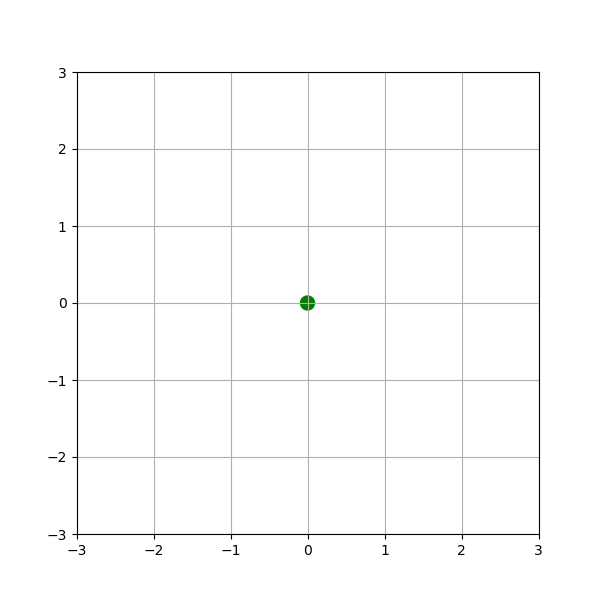

In [208]:
direct = linspace(0, 2*pi, 1000)

fig = figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3))
ax.set_aspect('equal')
ax.grid()

lines = [plot([],[])[0] for _ in range(4)]
circle = Circle([0.0, 0.0], radius=0.1, fc="g")
ax.add_artist(circle)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for line in lines:
        line.set_data([],[])
        line.set_color("k")
        time_text.set_text('')
    return lines, circle, time_text

def animate(i):
    x1 = x[i]+(D/2)*cos(direct)
    x2 = y[i]+(D/2)*sin(direct)
    lines[0].set_data(x1,x2)
    
    x0r=x[i]+(D/2)*sin(theta[i])
    y0r=y[i]-(D/2)*cos(theta[i])
    xrw=linspace(x0d-R*cos(theta[i]),x0d+R*cos(theta[i]),2)
    yrw=y0d+(xrw-x0d)*tan(theta[i])
    lines[1].set_data(xrw,yrw)
    
    x0l=x[i]+(D/2)*sin(theta[i]+pi)
    y0l=y[i]-(D/2)*cos(theta[i]+pi)
    xlw=linspace(x0l-R*cos(theta[i]),x0l+R*cos(theta[i]),2)
    ylw=y0l+(xlw-x0l)*tan(theta[i])
    lines[2].set_data(xlw,ylw)
    
    y1 = x[0:i+1]
    y2 = y[0:i+1]
    lines[3].set_data(y1,y2)
    
    circle.center = [x[i]+(D/2)*cos(theta[i]),y[i]+(D/2)*sin(theta[i])]
    time_text.set_text(time_template % (i*deltat))
    return lines, circle, time_text

ani = FuncAnimation(fig, animate, init_func=init, frames=range(0,len(Int)), blit=True, interval=deltat*1000, repeat=False)

show()

### Task - Trajectory Planning

Consider three pillars (of radius 10 cm) whose centers are aligned and distant of 3 meters, say at the locations
$$
(1.5,0), (4.5, 0) \mbox{ and } (7.5,0).
$$
Compute a reference trajectory trajectory that would lead the robot nose from $(0,0)$ (with a robot pointing to the right) to $(9,0)$ with a slalom between the pillars. Of course, you don't want the robot frame to bump into the pillars ! Display this trajectory graphically. What happens when if the inputs $\omega_l(t)$ and $\omega_r(t)$ are applied but the robot is not initially at the expected position ?


### Task - Exact (Partial) Linearization

Show that there is a function 
$$
(\omega_l, \omega_r) = \phi(X, u)
$$ 
-- where $u = (u_1, u_2)$ is an *auxiliary control* -- such that the robot nose coordinates satisfy
$$
\dot{x}_n = u_1 \mbox{ and } \dot{y}_n = u_2.
$$


### Task - Stabilization

Let $\Delta x_n = x_n - x_n^r$ and $\Delta y_n = y_n - y_n^r$. Can you find a control law $u$ such that $\Delta x_n$ and $\Delta y_n$ converge exponentially to $0$ with a prescribed time constant $T$ ? Consider again the slalom between the pillars when the initial configuration of the robot does not match the reference trajectory but with this new strategy and contrast with the previous attempt.